In [39]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [40]:
df = pd.read_csv('datasets/italian_real_estate_data.csv')

Print information about df

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200542 entries, 0 to 7200541
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   listing_id  uint64 
 1   semester    object 
 2   zone_link   object 
 3   location    object 
 4   region      object 
 5   prov        object 
 6   mun_istat   float64
 7   mun_cat     object 
 8   mun_cad     object 
 9   mun_name    object 
 10  sector      object 
 11  zone        object 
 12  type        object 
 13  condition   object 
 14  buy_min     float64
 15  buy_max     float64
 16  lease_min   float64
 17  lease_max   float64
dtypes: float64(5), object(12), uint64(1)
memory usage: 988.8+ MB


In [42]:
df.drop(columns=['listing_id','mun_istat']).describe()

,buy_min,buy_max,lease_min,lease_max
count,7.199002e+06,7.199002e+06,6.683583e+06,6.683583e+06
mean,7.942785e+02,1.071680e+03,3.166969e+00,4.363254e+00
std,6.178437e+02,8.474957e+02,2.405896e+00,3.398829e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+02,5.500000e+02,1.700000e+00,2.300000e+00
50%,6.400000e+02,8.500000e+02,2.600000e+00,3.500000e+00
75%,1.000000e+03,1.330000e+03,4.000000e+00,5.400000e+00
max,2.000000e+04,3.336000e+04,1.683000e+02,5.090000e+02


In [43]:
df.describe(include=['object'])

,semester,zone_link,location,region,prov,mun_cat,mun_cad,mun_name,sector,zone,type,condition
count,7200542,7200542,7200542,7200542,7051214,7200542,7200542,7200542,7200542,7200542,7200542,7104299
unique,42,42569,5,20,102,8234,8234,8220,5,393,19,3
top,2012_S2,SO00003215,NW,LOMBARDIA,AV,M1AA,H501,ROMA,B,B1,residential housing,normal
freq,188067,829,2173710,1148543,283132,60162,60162,60162,2867189,2262576,1130342,6164941


Handling missing values

In [44]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 listing_id         0
semester           0
zone_link          0
location           0
region             0
prov          149328
mun_istat         35
mun_cat            0
mun_cad            0
mun_name           0
sector             0
zone               0
type               0
condition      96243
buy_min         1540
buy_max         1540
lease_min     516959
lease_max     516959
dtype: int64


In [45]:
# Check in which region there are more missing 'prov' values
missing_province = df[df['prov'].isnull()]['region'].value_counts()
print("Missing 'prov' values by region:\n", missing_province)

Missing 'prov' values by region:
 region
CAMPANIA    149328
Name: count, dtype: int64


In [46]:
# Check municipalities with missing 'prov' values
missing_mun = df[df['prov'].isnull()]['mun_name'].value_counts()
print("Municipalities with missing 'prov' values:\n", missing_mun)

Municipalities with missing 'prov' values:
 mun_name
NAPOLI                     26705
POZZUOLI                    6160
CASTELLAMMARE DI STABIA     3504
NOLA                        3166
TORRE DEL GRECO             2715
                           ...  
SAN PAOLO BEL SITO           618
CARBONARA DI NOLA            580
COMIZIANO                    577
CASOLA DI NAPOLI             543
LIVERI                       540
Name: count, Length: 92, dtype: int64


In [47]:
df_1 = df.copy()

# Retreiving province codes from first two letters of zone_link
df_1.loc[df_1['prov'].isnull(), 'prov'] = df_1['zone_link'].str[:2]


print('Missing \'prov\' values:', df_1['prov'].isnull().sum())

# Print 'prov' values in CAMPANIA
print(df_1[df_1['region'] == 'CAMPANIA']['prov'].value_counts())

Missing 'prov' values: 0
prov
AV    283132
SA    150564
NA    149328
BN     41821
CE     35643
Name: count, dtype: int64


In [48]:
# Check for missing 'condition' values over regions
missing_condition = df_1[df_1['condition'].isnull()]['region'].value_counts()

region_distribution = df_1['region'].value_counts()

print("Distribution of observations by region:\n", (missing_condition*100/region_distribution))

# Fill missing 'condition' values with mode of the respective region
df_1['condition'] = df_1.groupby('region')['condition'].transform(lambda x: x.fillna(x.mode()[0]))

print("Missing 'condition' values after filling:", df_1['condition'].isnull().sum())

Distribution of observations by region:
 region
ABRUZZO                          1.315636
BASILICATA                       1.506490
CALABRIA                         1.822255
CAMPANIA                         0.960351
EMILIA-ROMAGNA                   1.327316
FRIULI-VENEZIA GIULIA            2.708021
LAZIO                            0.836371
LIGURIA                          2.458662
LOMBARDIA                        1.168785
MARCHE                           1.079149
MOLISE                           5.038710
PIEMONTE                         0.774645
PUGLIA                           1.323403
SARDEGNA                         1.608768
SICILIA                          1.949710
TOSCANA                          1.167558
TRENTINO-ALTO ADIGE              0.764734
UMBRIA                           1.042189
VALLE D'AOSTA/VALLE`E D'AOSTE    0.763201
VENETO                           1.381436
Name: count, dtype: float64
Missing 'condition' values after filling: 0


In [49]:
# Check for missing 'lease_min' or 'lease_max' values by 'type'
missing_lease = df_1['lease_min'].isnull() | df_1['lease_max'].isnull()

missing_by_type = df_1[missing_lease].groupby('type').size()

total_by_type = df_1['type'].value_counts()

# Percentage of missing lease per type
missing_percentage = (missing_by_type / df_1['type'].value_counts() * 100).fillna(0)

print("Missing 'lease_min' or 'lease_max' values by type (%):\n", missing_percentage)

Missing 'lease_min' or 'lease_max' values by type (%):
 type
covered parking spaces            3.676247
garage                            7.751376
garages                           1.864960
guesthouses and similar           3.636717
independent houses and villas    14.055893
industrial buildings              9.609441
laboratories                      5.852137
lowcost housing                   4.902212
luxury housing                   12.520614
offices                           5.228058
residential housing               9.661501
shopping centers                  3.598060
shops                             4.520581
sports facilities                 0.000000
structured offices                2.094494
typical industrial buildings      6.220628
typical local housing            31.472379
uncovered parking spaces          4.633005
warehouses                        4.720581
dtype: float64


In [50]:
# Fill missing 'lease_min' and 'lease_max' values with median of respective 'prov', 'sector', and 'type'
with warnings.catch_warnings(): # Ignore excessive warnings due to empty slices
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df_1['lease_min'] = df_1.groupby(['prov','sector','type'])['lease_min'].transform(lambda x: x.fillna(x.median()))

with warnings.catch_warnings(): # Ignore excessive warnings due to empty slices
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df_1['lease_max'] = df_1.groupby(['prov', 'sector', 'type'])['lease_max'].transform(lambda x: x.fillna(x.median()))

print("Missing 'lease_min' values after filling:", df_1['lease_min'].isnull().sum())
print("Missing 'lease_max' values after filling:", df_1['lease_max'].isnull().sum())

Missing 'lease_min' values after filling: 27456
Missing 'lease_max' values after filling: 27456


In [51]:
# Delete rows with missing 'buy_min', 'buy_max', 'lease_min' or 'lease_max' values
df_2 = df_1.dropna(subset=['buy_min', 'buy_max', 'lease_min', 'lease_max'])

missing_values_2 = df_2.isnull().sum()
print("Missing values in each column after cleaning:\n", missing_values_2)

Missing values in each column after cleaning:
 listing_id     0
semester       0
zone_link      0
location       0
region         0
prov           0
mun_istat     35
mun_cat        0
mun_cad        0
mun_name       0
sector         0
zone           0
type           0
condition      0
buy_min        0
buy_max        0
lease_min      0
lease_max      0
dtype: int64


Selecting housing properties

In [52]:
df_house = df_2.copy()

df_house = df_house[df_house['type'].isin(['residential housing', 'independent houses and villas', 'typical local housing'])]

print('Rows before selecting housing properties:', df_2.shape[0])
print('Rows after selecting housing properties:', df_house.shape[0])

print('Rows before selecting housing properties:', len(df_2))
print('Rows after selecting housing properties:', len(df_house))


Rows before selecting housing properties: 7171546
Rows after selecting housing properties: 1951159
Rows before selecting housing properties: 7171546
Rows after selecting housing properties: 1951159


Viasualise variables

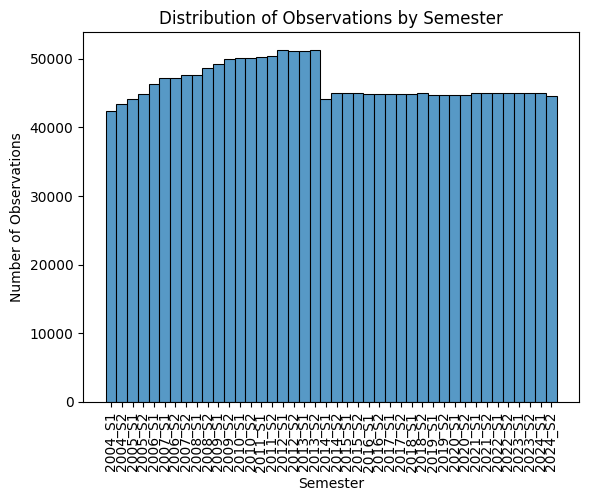

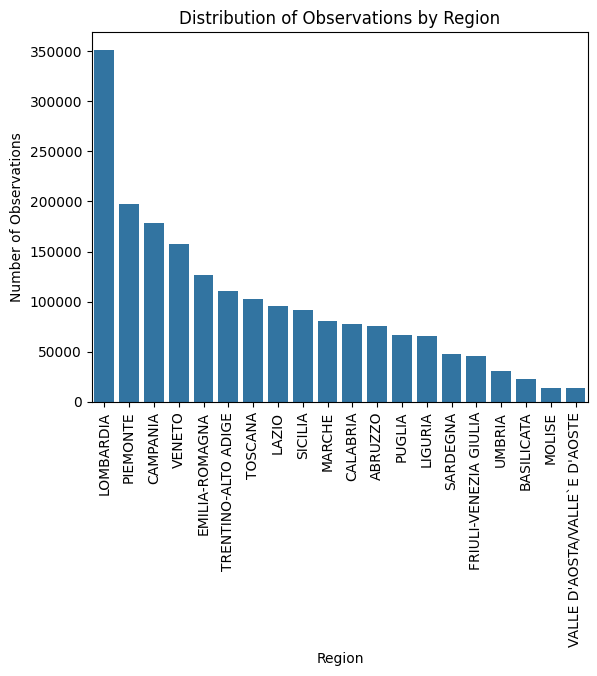

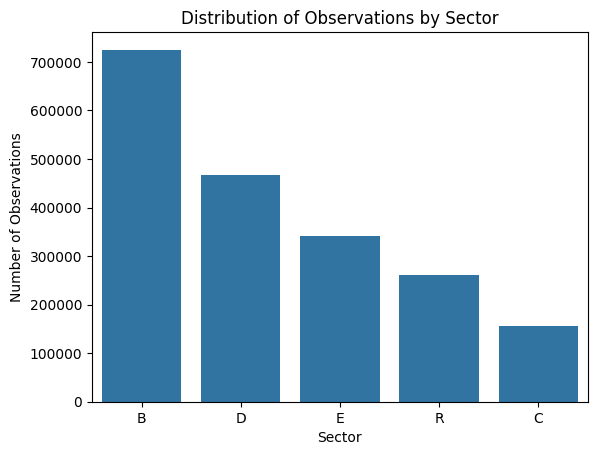

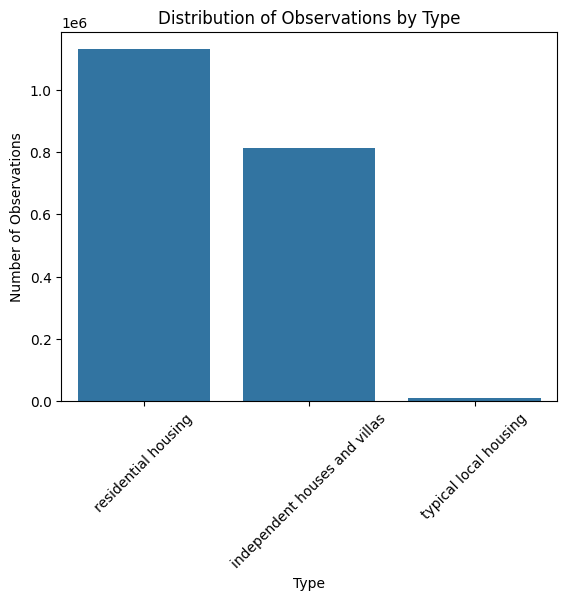

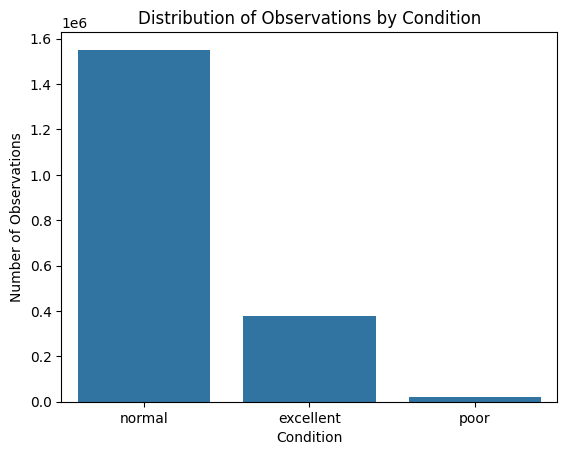

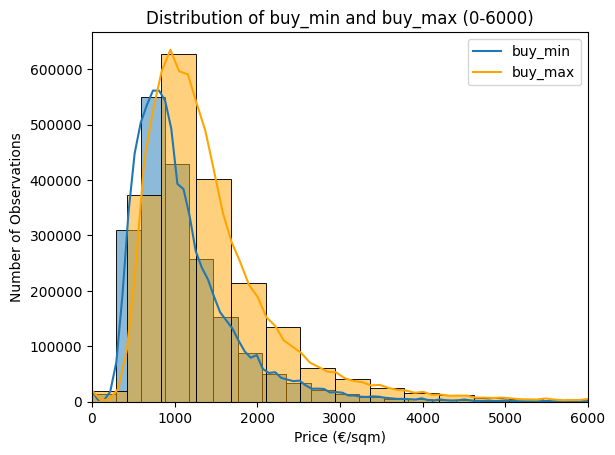

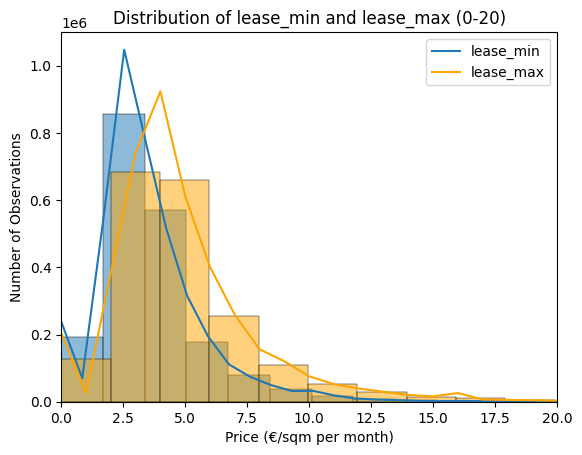

In [53]:
# Semester distribution
sns.histplot(data=df_house, x='semester', discrete=True)
plt.title('Distribution of Observations by Semester')
plt.xlabel('Semester')
plt.ylabel('Number of Observations')
plt.xticks(rotation=90)
plt.show()

# Region distribution
sns.countplot(data=df_house, x='region', order=df_house['region'].value_counts().index)
plt.title('Distribution of Observations by Region')
plt.xlabel('Region')
plt.ylabel('Number of Observations')
plt.xticks(rotation=90)
plt.show()

# Sector distribution
sns.countplot(data=df_house, x='sector', order=df_house['sector'].value_counts().index)
plt.title('Distribution of Observations by Sector')
plt.xlabel('Sector')
plt.ylabel('Number of Observations')
plt.show()

# Type distribution
sns.countplot(data=df_house, x='type', order=df_house['type'].value_counts().index)
plt.title('Distribution of Observations by Type')
plt.xlabel('Type')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.show()

# Condition dsitribution
sns.countplot(data=df_house, x='condition', order=df_house['condition'].value_counts().index)
plt.title('Distribution of Observations by Condition')
plt.xlabel('Condition')
plt.ylabel('Number of Observations')
plt.show()

# buy_min/max distribution
sns.histplot(data=df_house, x='buy_min', bins=50, kde=True)
sns.histplot(data=df_house, x='buy_max', bins=50, kde=True, color='orange')
plt.title('Distribution of buy_min and buy_max (0-6000)')
plt.xlabel('Price (€/sqm)')
plt.xlim(0, 6000)
plt.ylabel('Number of Observations')
plt.legend(['buy_min', 'buy_max'])
plt.show()

# lease_min/max distribution
sns.histplot(data=df_house, x='lease_min', bins=100, kde=True)
sns.histplot(data=df_house, x='lease_max', bins=100, kde=True, color='orange')
plt.title('Distribution of lease_min and lease_max (0-20)')
plt.xlabel('Price (€/sqm per month)')
plt.xlim(0, 20)
plt.ylabel('Number of Observations')
plt.legend(['lease_min', 'lease_max'])
plt.show()

Log transform buy/lease variables and center on the mean

In [54]:
# Check for '0' values in 'buy_min', 'buy_max', 'lease_min', 'lease_max'
zero_buy_min = (df_house['buy_min'] == 0).sum()
zero_buy_max = (df_house['buy_max'] == 0).sum()
zero_lease_min = (df_house['lease_min'] == 0).sum()
zero_lease_max = (df_house['lease_max'] == 0).sum()

print(f"Number of '0' values in 'buy_min': {zero_buy_min}")
print(f"Number of '0' values in 'buy_max': {zero_buy_max}")
print(f"Number of '0' values in 'lease_min': {zero_lease_min}")
print(f"Number of '0' values in 'lease_max': {zero_lease_max}")

# Check of '0' distribution over regions
zero_buy_min_region = df_house[df_house['buy_min'] == 0]['region'].value_counts()
zero_buy_max_region = df_house[df_house['buy_max'] == 0]['region'].value_counts()
zero_lease_min_region = df_house[df_house['lease_min'] == 0]['region'].value_counts()
zero_lease_max_region = df_house[df_house['lease_max'] == 0]['region'].value_counts()

print("Distribution of '0' values in 'buy_min' by region:\n", zero_buy_min_region)
print("Distribution of '0' values in 'buy_max' by region:\n", zero_buy_max_region)
print("Distribution of '0' values in 'lease_min' by region:\n", zero_lease_min_region)
print("Distribution of '0' values in 'lease_max' by region:\n", zero_lease_max_region)


Number of '0' values in 'buy_min': 6440
Number of '0' values in 'buy_max': 6440
Number of '0' values in 'lease_min': 43406
Number of '0' values in 'lease_max': 43406
Distribution of '0' values in 'buy_min' by region:
 region
MARCHE            3570
ABRUZZO           1564
UMBRIA             765
EMILIA-ROMAGNA     303
LAZIO              213
SICILIA             22
TOSCANA              3
Name: count, dtype: int64
Distribution of '0' values in 'buy_max' by region:
 region
MARCHE            3570
ABRUZZO           1564
UMBRIA             765
EMILIA-ROMAGNA     303
LAZIO              213
SICILIA             22
TOSCANA              3
Name: count, dtype: int64
Distribution of '0' values in 'lease_min' by region:
 region
VENETO                           24794
TOSCANA                           7595
EMILIA-ROMAGNA                    4742
MOLISE                            3965
LOMBARDIA                         1078
SICILIA                            519
CALABRIA                           299
VALLE D'

In [55]:
# Transform '0' values to NaN for imputation
with warnings.catch_warnings(): # Ignore excessive warnings due to empty slices
    warnings.simplefilter("ignore", category=FutureWarning)
    df_house['buy_min'].replace(0, np.nan, inplace=True)
    df_house['buy_max'].replace(0, np.nan, inplace=True)
    df_house['lease_min'].replace(0, np.nan, inplace=True)
    df_house['lease_max'].replace(0, np.nan, inplace=True)

# Substitute NaN values in buy_min and buy_max with median of respective 'prov', 'sector' and 'type'
with warnings.catch_warnings(): # Ignore excessive warnings due to empty slices
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df_house['buy_min'] = df_house.groupby(['prov','sector','type'])['buy_min'].transform(lambda x: x.fillna(x.median()))
    df_house['buy_max'] = df_house.groupby(['prov','sector','type'])['buy_max'].transform(lambda x: x.fillna(x.median()))

print("Missing 'buy_min' values after filling:", df_house['buy_min'].isnull().sum())
print("Missing 'buy_max' values after filling:", df_house['buy_max'].isnull().sum())

# Substitute NaN values in lease_min and lease_max with median of respective 'prov', 'sector' and 'type'
with warnings.catch_warnings(): # Ignore excessive warnings due to empty slices
    warnings.simplefilter("ignore", category=RuntimeWarning)
    df_house['lease_min'] = df_house.groupby(['prov','sector','type'])['lease_min'].transform(lambda x: x.fillna(x.median()))
    df_house['lease_max'] = df_house.groupby(['prov','sector','type'])['lease_max'].transform(lambda x: x.fillna(x.median()))

print("Missing 'lease_min' values after filling:", df_house['lease_min'].isnull().sum())
print("Missing 'lease_max' values after filling:", df_house['lease_max'].isnull().sum())

Missing 'buy_min' values after filling: 0
Missing 'buy_max' values after filling: 0
Missing 'lease_min' values after filling: 16176
Missing 'lease_max' values after filling: 16176


In [56]:
# Delete rows with lease_min or lease_max equal to NaN
df_house = df_house.dropna(subset=['lease_min', 'lease_max'])

missing_values_final = df_house.isnull().sum()
print("Missing values in each column after final cleaning:\n", missing_values_final)

Missing values in each column after final cleaning:
 listing_id    0
semester      0
zone_link     0
location      0
region        0
prov          0
mun_istat     0
mun_cat       0
mun_cad       0
mun_name      0
sector        0
zone          0
type          0
condition     0
buy_min       0
buy_max       0
lease_min     0
lease_max     0
dtype: int64


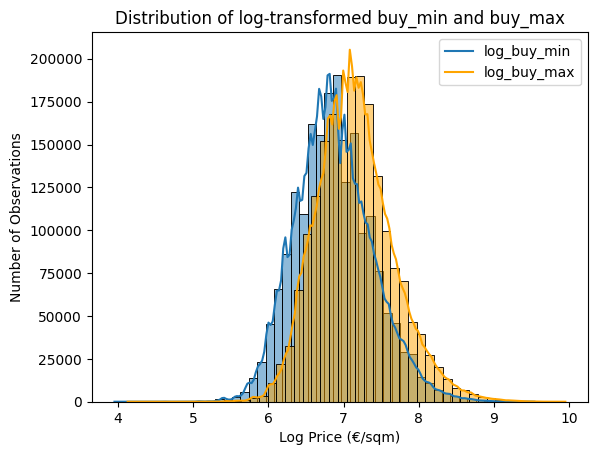

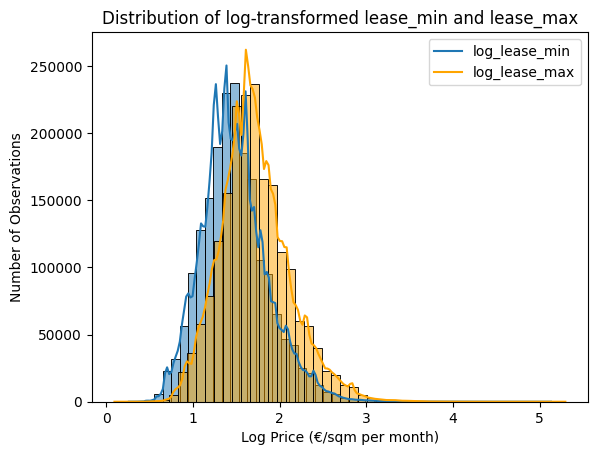

In [ ]:
 , , , , ,mnmnknknknknknkodl,kms#Log transform buy/lease variables
df_house['log_buy_min'] = np.log1p(df_house['buy_min'])
df_house['log_buy_max'] = np.log1p(df_house['buy_max'])
df_house['log_lease_min'] = np.log1p(df_house['lease_min'])
df_house['log_lease_max'] = np.log1p(df_house['lease_max'])

# Visualize log-transformed buy_min/max distribution
sns.histplot(data=df_house, x='log_buy_min', bins=50, kde=True)
sns.histplot(data=df_house, x='log_buy_max', bins=50, kde=True, color='orange')
plt.title('Distribution of log-transformed buy_min and buy_max')
plt.xlabel('Log Price (€/sqm)')
plt.ylabel('Number of Observations')
plt.legend(['log_buy_min', 'log_buy_max'])
plt.show()

# Visualize log-transformed lease_min/max distribution
sns.histplot(data=df_house, x='log_lease_min', bins=50, kde=True)
sns.histplot(data=df_house, x='log_lease_max', bins=50, kde=True, color='orange')
plt.title('Distribution of log-transformed lease_min and lease_max')
plt.xlabel('Log Price (€/sqm per month)')
plt.ylabel('Number of Observations')
plt.legend(['log_lease_min', 'log_lease_max'])
plt.show()

In [58]:
# Create year and semester variables
df_house['year'] = df_house['semester'].str[:4].astype(int)
df_house['semester'] = df_house['semester'].str[6:].astype(int)

df_house.head(10)

,listing_id,semester,zone_link,location,region,prov,mun_istat,mun_cat,mun_cad,mun_name,...,condition,buy_min,buy_max,lease_min,lease_max,log_buy_min,log_buy_max,log_lease_min,log_lease_max,year
0,17811240733772113484,1,AL00000001,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,1110.0,1670.0,3.7,5.6,7.013016,7.421178,1.547563,1.887070,2004
8,17186526586515084542,1,AL00000003,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,860.0,1270.0,3.2,4.8,6.758095,7.147559,1.435085,1.757858,2004
12,2280114108509459433,1,AL00000003,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,940.0,1220.0,3.5,4.1,6.846943,7.107425,1.504077,1.629241,2004
19,16830093516912961020,1,AL00000005,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,480.0,680.0,1.9,2.5,6.175867,6.523562,1.064711,1.252763,2004
21,18325523195574493031,1,AL00000005,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,680.0,990.0,2.9,3.7,6.523562,6.898715,1.360977,1.547563,2004
28,6048941544737335608,1,AL00000006,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,580.0,760.0,2.1,2.8,6.364751,6.634633,1.131402,1.335001,2004
31,1738081965682015651,1,AL00000006,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,710.0,930.0,2.6,3.4,6.566672,6.836259,1.280934,1.481605,2004
38,7469317920844901206,1,AL00003420,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,800.0,1090.0,3.0,4.1,6.685861,6.994850,1.386294,1.629241,2004
41,11376315080141646081,1,AL00003420,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,810.0,1110.0,3.0,4.2,6.698268,7.013016,1.386294,1.648659,2004
48,16370084365386078358,1,AL00003421,NW,PIEMONTE,AL,1006003.0,A2AA,A182,ALESSANDRIA,...,normal,660.0,910.0,2.4,3.4,6.493754,6.814543,1.223775,1.481605,2004


In [ ]:
new_order = [
    "listing_id", "year", "semester", "zone_link", "location", "region", "prov", "mun_istat", "mun_cat", "mun_cad", 
    "mun_name", "sector", "zone", "type", "condition", "buy_min", "buy_max", "lease_min", "lease_max", "log_buy_min", 
    "log_buy_max", "log_lease_min", "log_lease_max"
]

df_house = df_house[new_order]

df_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1934983 entries, 0 to 7200534
Data columns (total 23 columns):
 #   Column         Dtype  
---  ------         -----  
 0   listing_id     uint64 
 1   year           int64  
 2   semester       int64  
 3   zone_link      object 
 4   location       object 
 5   region         object 
 6   prov           object 
 7   mun_istat      float64
 8   mun_cat        object 
 9   mun_cad        object 
 10  mun_name       object 
 11  sector         object 
 12  zone           object 
 13  type           object 
 14  condition      object 
 15  buy_min        float64
 16  buy_max        float64
 17  lease_min      float64
 18  lease_max      float64
 19  log_buy_min    float64
 20  log_buy_max    float64
 21  log_lease_min  float64
 22  log_lease_max  float64
dtypes: float64(9), int64(2), object(11), uint64(1)
memory usage: 354.3+ MB


In [ ]:
df_house.to_csv('datasets/house_data.csv', sep = ',', index=False, encoding='utf-8-sig')